In [1]:
from funcs import *

# Duplicate Question Classifier 
In this notebook, we take a stab at the quora question pair dataset via kaggle. The object is to build a classifier which can detect 'duplicate questions'. As you will see below, some of these questions get <i>very</i> 
similar while meaning entirely different things. Our hypothesis is that by breaking up a question pair by part of speech (ie noun, verb..), we can achieve more accurate results than comparing the questions on whole, while maintaining some interpretability.

### Data From Kaggle/Quora: https://www.kaggle.com/quora/question-pairs-dataset
### Language Model from SpaCy: https://spacy.io/models/en#en_core_web_lg




In [2]:
raw = pd.read_csv('questions.csv')
nlp = spacy.load('en_core_web_sm')

Ensure the data are loaded correctly:

In [3]:
raw.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Inspecting some questions:


In [4]:
def question_pair_gen(df, range_, start=None):
    index = iter(range(range_))
    if start:
        for n in range(start):
            next(index)
    while True:
        next_ind = next(index)
        print(raw['question1'].loc[next_ind])
        print(raw['question2'].loc[next_ind])
        print('Duplicate ' if raw.is_duplicate.loc[next_ind] else 'Not Duplicate')
        yield 

In [5]:
qcheck= question_pair_gen(raw,200000,10000)

In [6]:
next(qcheck)

Is it safe for a woman to travel alone in Vietnam?
Is it safe for a woman to travel alone in Japan?
Not Duplicate


In [7]:
next(qcheck)

What do paving stones cost?
What are "paving stones"?
Not Duplicate


In [8]:
next(qcheck)

Is it an irony of Bengaluru that the people who come from other states are its biggest critics?
Have you read 50 Shades Of Grey? If so, did it turn you on?
Not Duplicate


### Check and Remove Null Values:

In [9]:
raw.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [4]:
len(raw)-len(raw.dropna())

3

In [10]:
raw.dropna(inplace=True)

In [11]:
raw.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [12]:
# Building the training set
first_100k_true = raw[raw.is_duplicate==1][:100_000]
first_100k_false = raw[raw.is_duplicate==0][:100_000]
train = first_100k_false.append(first_100k_true).reset_index(drop=True)


In [13]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [14]:

def prepare(traindf):
    #create iterators of question columns
    #nlp.pipe takes an iterator and returns a spacy pipeline generator 
    q1_docs_ = nlp.pipe(iter(traindf['question1'].str.lower())) 
    q2_docs_ = nlp.pipe(iter(traindf['question2'].str.lower()))
    return zip(q1_docs_,q2_docs_)
    
def parse(doc_pairs, keep_docs=True, keep_text=False):
    #This is the meat of the processing. Set keep docs to false to save memory if you only want the
    #engineered features 
    
    feat_dict = defaultdict(list)
    pos_list = ['noun','verb','adj','adv']

    for q1, q2 in tqdm(doc_pairs):
        if keep_docs:
            feat_dict['q1_docs'].append(q1)
            feat_dict['q2_docs'].append(q2)
        if keep_text:
            feat_dict['q1_txt'].append(q1.text)
            feat_dict['q2_txt'].append(q2.text)

        #Document semantic similarity and similarity of differences (cosine similarity)
        feat_dict['sim'].append(q1.similarity(q2))
        feat_dict['sim_of_diffs'].append(sim_of_diffs(q1,q2))
        
        #Part of Speech semantic similarity, s.o.d., and fuzzy match ratio
        for pos in pos_list:
            feat_dict[f'sim_of_{pos}s'].append(sim_by_pos(q1,q2,pos))
            feat_dict[f'sim_of_diffs_{pos}s'].append(sim_of_diffs(q1,q2,pos=pos))
            feat_dict[f'{pos}_mratio'].append(pos_match_ratio(q1,q2,pos))
            
        #Proper Noun and entity match ratios
        feat_dict['propn_mratio'].append(pos_match_ratio(q1,q2,'propn'))
        feat_dict['ent_ratio'].append(ent_match_ratio(q1,q2))
        feat_dict['ent_type_match_ratio'].append(ent_type_match_ratio(q1,q2))

    return pd.DataFrame(data=feat_dict)


In [15]:
prepare(train)

In [20]:
df = parse(prepare(train)) # <====TAKES A WHILE


200000it [20:13, 164.85it/s]


In [21]:
labeled_df = pd.concat([y,df],axis=1)

In [28]:
X=labeled_df.iloc[:,3:]
y = train.is_duplicate #We'll grab this from earlier...

In [29]:
X.to_pickle('X.pickle')
y.to_pickle('y.pickle')

In [30]:
X = pd.read_pickle('X.pickle')
y = pd.read_pickle('y.pickle')

In [33]:
labeled_df.head()

,is_duplicate,q1_docs,q2_docs,sim,sim_of_diffs,sim_of_nouns,sim_of_diffs_nouns,noun_mratio,sim_of_verbs,sim_of_diffs_verbs,verb_mratio,sim_of_adjs,sim_of_diffs_adjs,adj_mratio,sim_of_advs,sim_of_diffs_advs,adv_mratio,propn_mratio,ent_ratio,ent_type_match_ratio
0,0,"(what, is, the, step, by, step, guide, to, inv...","(what, is, the, step, by, step, guide, to, inv...",0.978653,0.000000,0.981263,0.000000,0.92,0.999998,0.000000,1.00,0.000000,0.0,1.0,0.000000,0.000000,1.00,1.0,0.0,0.0
1,0,"(what, is, the, story, of, kohinoor, (, koh, -...","(what, would, happen, if, the, indian, governm...",0.784920,0.509711,0.835140,0.732593,0.60,0.174786,0.174786,0.17,0.821365,0.0,0.8,0.000000,0.000000,0.00,1.0,1.0,1.0
2,0,"(how, can, i, increase, the, speed, of, my, in...","(how, can, internet, speed, be, increased, by,...",0.680107,0.538262,0.769711,0.644852,0.43,0.542756,0.297923,0.66,0.000000,0.0,0.0,0.985946,0.000000,1.00,1.0,1.0,1.0
3,0,"(why, am, i, mentally, very, lonely, ?, how, c...","(find, the, remainder, when, [, math]23^{24}[/...",0.351391,0.246442,0.000000,0.000000,0.00,0.341638,0.362697,0.46,0.000000,0.0,0.0,0.443763,0.443763,0.38,1.0,0.0,0.0
4,0,"(which, one, dissolve, in, water, quikly, suga...","(which, fish, would, survive, in, salt, water, ?)",0.693504,0.367157,0.831812,0.624656,0.44,0.409830,0.409830,0.46,0.834070,0.0,1.0,0.000000,0.000000,0.00,1.0,1.0,1.0


In [169]:
def feature_sampler(index,df=None,y=None):
    assert index
    test1,test2 = (df.q1_docs.loc[index],df.q2_docs.loc[index])
    pos_list = ['noun','verb','adj','adv']
    print('question 1: ',test1)
    print('question 2: ',test2)
    print('label: ','duplicate' if y.loc[index] else 'not duplicate')
    print('\n')
    print('similarities: ', test1.similarity(test2))
    print('similarity of differences: ',sim_of_diffs(test1,test2))

    for pos in pos_list:

        print('\n _______%ss_______'%pos)
        print(get_pos_tags(test1,test2,pos))
        print('%s_matchratio: '%pos,pos_match_ratio(test1,test2,pos))
        print('sim: ',sim_by_pos(test1,test2,pos))
        print('s.o.d.s: ',sim_of_diffs(test1,test2,pos=pos))

    print('\n _______Proper_Nouns_______')
    print(get_pos_tags(test1,test2,'propn'))
   # print('has_propns: ',both_have_pos((test1,test2),'propn'))
    print('propn_matchratio:',pos_match_ratio(test1,test2,'propn'))
    print('sim: ',sim_by_pos(test1,test2,'propn'))
    print('s.o.d.s: ',sim_of_diffs(test1,test2,pos='propn'))

    print('\n _______Entities_______')
    print(get_ents((test1,test2)))
    print('ent_matchratio: ',ent_match_ratio(test1,test2))
    #print('has_ents: ',both_have_ents((test1,test2)))


    print('\n _______Entity_Types_______')
    print(get_ent_types((test1,test2)))
    print('ent_type_match ratio: ',ent_type_match_ratio(test1,test2))


In [198]:
feature_sampler(np.random.randint(0,200000),df=labeled_df,y=y)

question 1:  how's indian economy and chinese economy is affected if it closes china product in indian market?
question 2:  india: will boycotting chinese product impact their economy without affecting ours?
label:  duplicate


similarities:  0.7366661580477052
similarity of differences:  0.55738455

 _______nouns_______
([economy, economy, china, product, market], [india, product, impact, economy])
noun_matchratio:  0.51
sim:  0.86878335
s.o.d.s:  0.60899127

 _______verbs_______
([is, affected, closes], [will, boycotting, affecting])
verb_matchratio:  0.43
sim:  0.24333858
s.o.d.s:  0.18850714

 _______adjs_______
([indian, chinese, indian], [chinese, their])
adj_matchratio:  0.59
sim:  0.66550094
s.o.d.s:  0.27831522

 _______advs_______
([how], [])
adv_matchratio:  0.0
sim:  0
s.o.d.s:  0

 _______Proper_Nouns_______
([], [])
propn_matchratio: 1.0
sim:  0
s.o.d.s:  0

 _______Entities_______
([chinese, china], [india, chinese])
ent_matchratio:  0.62

 _______Entity_Types_______
(['

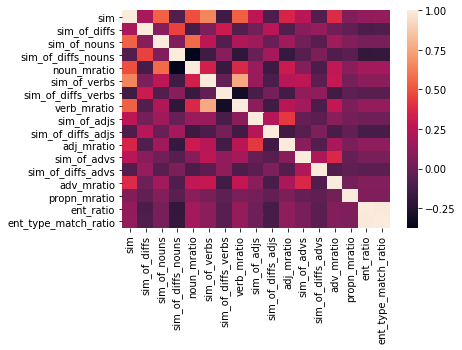

In [68]:
sns.heatmap(X.corr())

In [77]:
labeled_df.shape

(200000, 20)

/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


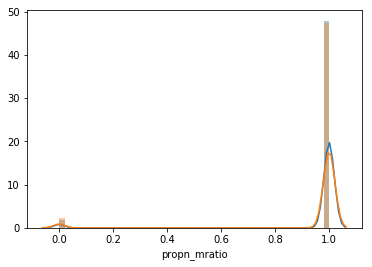

In [78]:

plt.subplot()
sns.distplot(X.loc[len(X)/2:].propn_mratio)
sns.distplot(X.loc[:len(X)/2].propn_mratio)

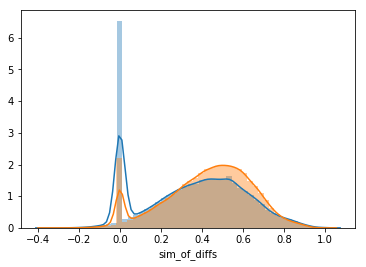

In [79]:
sns.distplot(X.loc[len(X)/2:].sim_of_diffs)
sns.distplot(X.loc[:len(X)/2].sim_of_diffs)

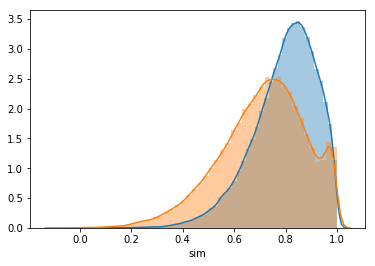

In [80]:
sns.distplot(X.loc[len(X)/2:].sim)
sns.distplot(X.loc[:len(X)/2].sim)

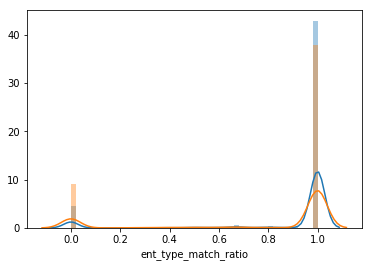

In [81]:
sns.distplot(X.loc[len(X)/2:].ent_type_match_ratio)
sns.distplot(X.loc[:len(X)/2].ent_type_match_ratio)

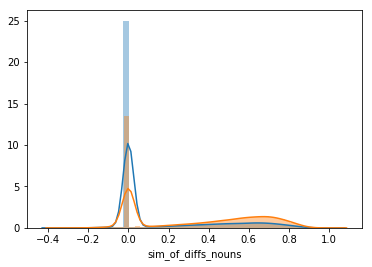

In [82]:
sns.distplot(X.loc[len(X)/2:].sim_of_diffs_nouns)
sns.distplot(X.loc[:len(X)/2].sim_of_diffs_nouns)

In [87]:
X_no_pos = X[['sim','sim_of_diffs']]
X_only_pos = X.iloc[:,2:]
X_only_pos.head()

,sim_of_nouns,sim_of_diffs_nouns,noun_mratio,sim_of_verbs,sim_of_diffs_verbs,verb_mratio,sim_of_adjs,sim_of_diffs_adjs,adj_mratio,sim_of_advs,sim_of_diffs_advs,adv_mratio,propn_mratio,ent_ratio,ent_type_match_ratio
0,0.981263,0.000000,0.92,0.999998,0.000000,1.00,0.000000,0.0,1.0,0.000000,0.000000,1.00,1.0,0.0,0.0
1,0.835140,0.732593,0.60,0.174786,0.174786,0.17,0.821365,0.0,0.8,0.000000,0.000000,0.00,1.0,1.0,1.0
2,0.769711,0.644852,0.43,0.542756,0.297923,0.66,0.000000,0.0,0.0,0.985946,0.000000,1.00,1.0,1.0,1.0
3,0.000000,0.000000,0.00,0.341638,0.362697,0.46,0.000000,0.0,0.0,0.443763,0.443763,0.38,1.0,0.0,0.0
4,0.831812,0.624656,0.44,0.409830,0.409830,0.46,0.834070,0.0,1.0,0.000000,0.000000,0.00,1.0,1.0,1.0


In [88]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_npos_train,X_npos_test,yn_train,yn_test = train_test_split(X_no_pos,y)
X_opos_train,X_opos_test,yo_train,yo_test = train_test_split(X_only_pos,y)

## Fitting with Only Parts of Speech 

In [89]:
logreg = LogisticRegression(fit_intercept = False, C = .1, tol=.000001)
logreg.fit(X_opos_train, yo_train)

y_hat_train = logreg.predict(X_opos_train)
y_hat_test = logreg.predict(X_opos_test)


residuals = yo_test - y_hat_test
print(pd.Series(residuals).value_counts(normalize=True))
print(confusion_matrix(yo_test, y_hat_test))

/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 0    0.67108
-1    0.18724
 1    0.14168
Name: is_duplicate, dtype: float64
[[15565  9362]
 [ 7084 17989]]


## Fitting with Only Doc Sim + S.o.D

In [90]:

logreg = LogisticRegression(fit_intercept = True,C = 1,tol=.01,)
logreg.fit(X_npos_train, yn_train)

y_hat_train = logreg.predict(X_npos_train)
y_hat_test = logreg.predict(X_npos_test)


residuals = yn_test - y_hat_test
print(pd.Series(residuals).value_counts(normalize=True))

print(logreg.score(X_npos_test,yn_test))
print(confusion_matrix(yn_test, y_hat_test))

 0    0.65034
 1    0.17950
-1    0.17016
Name: is_duplicate, dtype: float64
0.65034
[[16740  8508]
 [ 8975 15777]]


/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Fitting w/All Features

In [168]:

logreg = LogisticRegression(fit_intercept = None, C = .1, tol=.01, penalty='l2')
logreg.fit(X_train, y_train)

y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)


residuals = y_test - y_hat_test
print(pd.Series(residuals).value_counts(normalize=True))

print(logreg.score(X_test,y_test))
print(confusion_matrix(y_test, y_hat_test))

/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 0    0.67134
-1    0.18122
 1    0.14744
Name: is_duplicate, dtype: float64
0.67134
[[15815  9061]
 [ 7372 17752]]


In [150]:
mean_lg_cv_score = np.mean(cross_val_score(logreg, X, y, cv=3))
print("Mean Cross Validation Score for Logistic Classifier: {:.4}%".format(mean_lg_cv_score * 100))



/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Cross Validation Score for Logistic Classifier: 67.17%


In [151]:
from sklearn import linear_model
sgdclf = linear_model.SGDClassifier(loss='hinge',max_iter=10000, tol=1e-3,alpha=.0001,
                                    penalty='elasticnet',l1_ratio=.8)
sgdclf.fit(X_train, y_train)

y_hat_train = sgdclf.predict(X_train)
y_hat_test = sgdclf.predict(X_test)


#y_test_array = np.array(y_test['is_duplicate'])
residuals = y_test - y_hat_test
pd.Series(residuals).value_counts()
pd.Series(residuals).value_counts(normalize=True)

print(sgdclf.score(X_test,y_test))
print(confusion_matrix(y_test, y_hat_test))


0.68006
[[14653 10223]
 [ 5774 19350]]


In [152]:
sgdclf.score(X_test,y_test)

0.68006

In [153]:
def plot_feature_importances(model,X):
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")


In [106]:
rf_clfnpos = RandomForestClassifier(criterion= 'gini',max_features=2, max_depth= None, min_samples_leaf= 5,
                                    min_samples_split= 20, n_estimators= 100)
rf_clfnpos.fit(X_npos_train,yn_train)
mean_rf_cv_score = np.mean(cross_val_score(rf_clfnpos, X_no_pos, y, cv=3))
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))


Mean Cross Validation Score for Random Forest Classifier: 64.96%


In [167]:
plot_feature_importances(logreg,X)

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

<Figure size 576x576 with 0 Axes>

In [111]:
rf_clfopos = RandomForestClassifier(criterion= 'gini',max_features=2, max_depth= None, min_samples_leaf= 5, min_samples_split= 20, n_estimators= 100)
rf_clfopos.fit(X_opos_train,yo_train)
mean_rf_cv_score = np.mean(cross_val_score(rf_clfopos, X_only_pos, y, cv=3))
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))


Mean Cross Validation Score for Random Forest Classifier: 72.64%


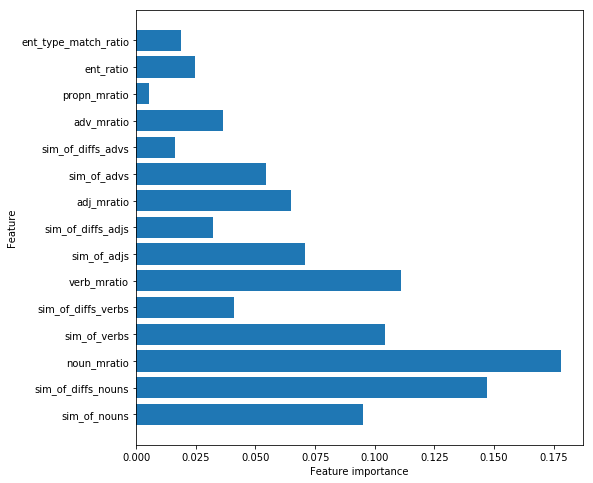

In [112]:
plot_feature_importances(rf_clfopos,X_opos_train)


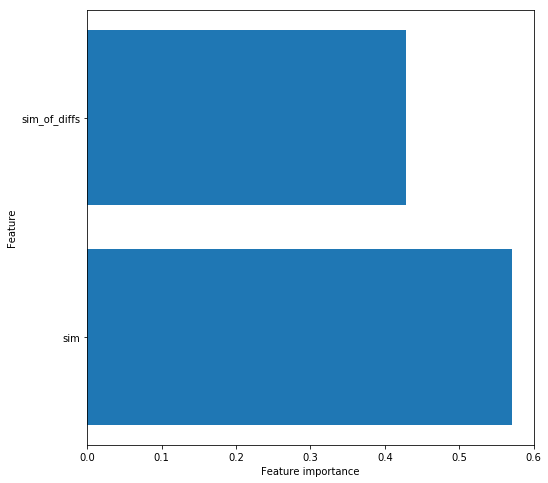

In [123]:
rf_clf = RandomForestClassifier(criterion= 'gini',max_features=2, max_depth= None, min_samples_leaf= 5, min_samples_split= 20, n_estimators= 100)
rf_clf.fit(X_train,y_train)
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X, y, cv=3))
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))


Mean Cross Validation Score for Random Forest Classifier: 73.39%


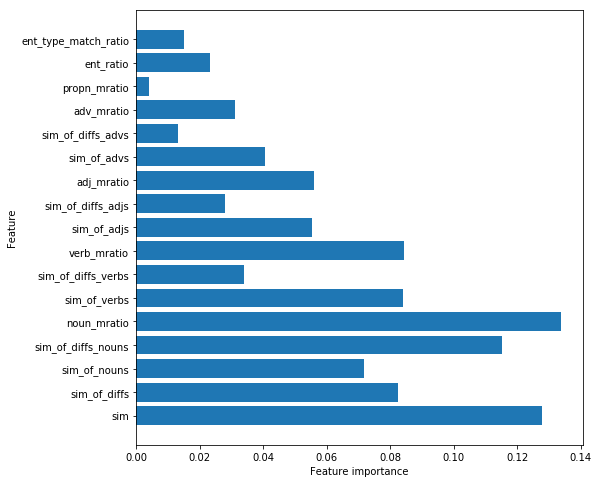

In [124]:
plot_feature_importances(rf_clf,X)


In [118]:
# rf_param_grid = {
#     'n_estimators': [50,100],
#     'criterion': ['gini'],
#     'max_depth': [1,5,10,15],
#     'min_samples_split': [20,50],
#     'min_samples_leaf': [1, 2, 5],
#     'max_features': [None,2,5]
# }

# start = time.time()
# rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
# rf_grid_search.fit(X, y)

# print("Testing Accuracy: {:.4}%".format(rf_grid_search.best_score_ * 100))
# print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
# print("")
# print("Optimal Parameters: {}".format(rf_grid_search.best_params_))


In [125]:
from sklearn.ensemble import AdaBoostClassifier
adaclf = AdaBoostClassifier(n_estimators=100)
adaclf.fit(X_train,y_train)
mean_rf_cv_score = np.mean(cross_val_score(adaclf, X, y, cv=3))
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))

Mean Cross Validation Score for Random Forest Classifier: 70.08%


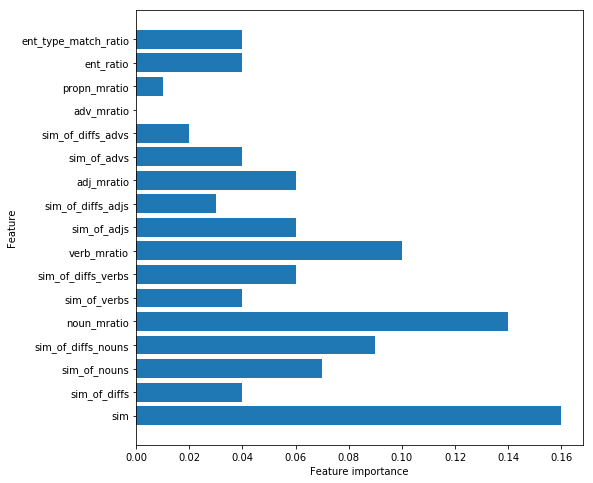

In [122]:
plot_feature_importances(adaclf,X)

In [163]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(max_depth=50,learning_rate=.1,
                            reg_alpha=.1,reg_lambda=1,gamma=0,
                           min_child_weight=1, colsample_bylevel=.9,
                           colsample_bytree=.9,
                           n_estimators=100,n_jobs=4)

In [164]:
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=50, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [161]:
xgb_clf.score(X_test,y_test)

0.74066

In [162]:
mean_xg_cv_score = np.mean(cross_val_score(xgb_clf, X, y, cv=3,verbose=2))
print("Mean Cross Validation Score for XGB Classifier: {:.4}%".format(mean_xg_cv_score * 100))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  29.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.2s remaining:    0.0s


[CV] ................................................. , total=  29.3s
[CV]  ................................................................
[CV] ................................................. , total=  29.4s
Mean Cross Validation Score for XGB Classifier: 73.64%


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished


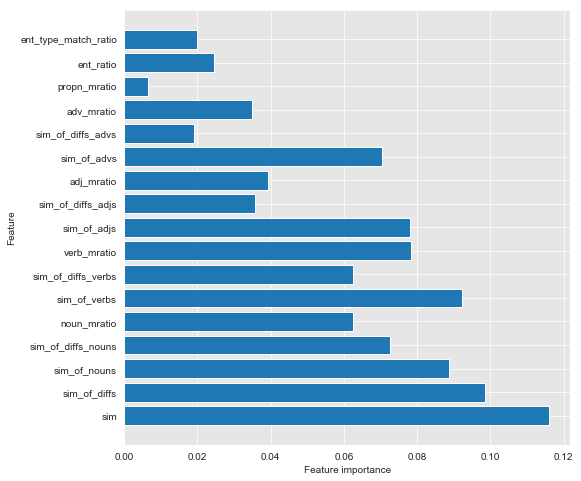

In [145]:
plot_feature_importances(xgb_clf,X)

In [165]:
from sklearn.metrics import roc_curve, auc

y_score = xgb_clf.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

y_train_score = rf_clf.predict(X_train)
train_fpr, train_tpr, thresholds = roc_curve(y_test, y_score)


AUC: 0.7402543010402125


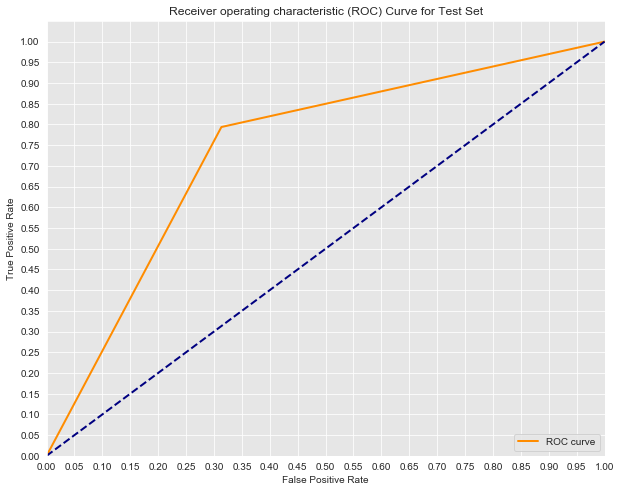

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()